In [1]:
from scipy.special import expit
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from utils_hpd import hpd_grid
from utils_dataset import *
from utils_sampling import *
from utils_models import *
from funcs_model_predictions import *
from funcs_model_fit_evaluate import *

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 28})
plt.rcParams.update({'font.family': 'arial'})

In [3]:
datasetName = 'takahashi2016roesch2009burton2018Valid'
dataValid = pd.read_csv('data/' + datasetName + '.csv')

In [4]:
def transform_beta(x):
    # Phi_approx(x) = logit^{-1}(0.07056 x^3 + 1.5976 x)
    return expit(0.07056*(x**3) + 1.5976*x)*10

def transform_w(x):
    # Phi_approx(x) = logit^{-1}(0.07056 x^3 + 1.5976 x)
    return expit(0.07056*(x**3) + 1.5976*x)

def transform_eta(x):
    # Phi_approx(x) = logit^{-1}(0.07056 x^3 + 1.5976 x)
    return expit(0.07056*(x**3) + 1.5976*x)

### Load fitted parameters

In [5]:
allSamples = pd.read_csv('model_fits/' + datasetName + '_hybridValue_full_allSamples.csv')

NStates = [4,6]
w = dict.fromkeys([str(NState)+'group' for NState in NStates] + [str(NState) for NState in NStates])
w['w4group'] = allSamples.loc[allSamples['warmup']==0, 'mu_pr[2]'].values
w['w4'] = allSamples.loc[allSamples['warmup']==0, [col for col in allSamples if col.startswith('w4[')>0]].values

In [6]:
allSamples = pd.read_csv('model_fits/'+datasetName+'_hybridLearning_full_allSamples.csv')

etaNameList = ['eta', 'eta4state']
etas = dict.fromkeys([etaName+'_group' for etaName in etaNameList] + etaNameList)
for etaName in etaNameList:
    etas[etaName+'_group'] = allSamples.loc[allSamples['warmup']==0, 'mu_pr[' + str(etaNameList.index(etaName)+2) + ']'].values
    etas[etaName] = allSamples.loc[allSamples['warmup']==0, [col for col in allSamples if col.startswith(etaName+'[')>0]].values

In [7]:
df = pd.DataFrame()
df['avgreward'] = [dataValid.groupby('rat')['rewardAmount'].mean()[iRat] for iRat in dataValid['rat'].unique()]
df['dataset'] = [rat2dataset[iRat] for iRat in dataValid['rat'].unique()]
df['w4'] = [np.mean(w['w4'][:,iRat-1]) for iRat in dataValid['rat'].unique()]
df['eta'] = [np.mean(etas['eta'][:,iRat-1]) for iRat in dataValid['rat'].unique()]
df['etag'] = [np.mean(etas['eta4state'][:,iRat-1]) for iRat in dataValid['rat'].unique()]

### $w_4$ (hybrid-value model)

#### Group-level parameters (95% HDI)

95% HDI w4_group: (0.05, 0.28)


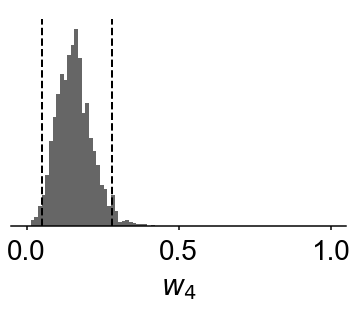

In [8]:
intervals4 = hpd_grid(transform_w(w['w4group']), alpha=0.05)[0][0]
intervals6 = hpd_grid(1 - transform_w(w['w4group']), alpha=0.05)[0][0]
intervals_diff = hpd_grid(1 - transform_w(w['w4group'])-transform_w(w['w4group']), alpha=0.05)[0][0]

fig, ax = plt.subplots()
# sns.distplot(1 - transform_w(w['w4group']), label='w(6-state)')
sns.distplot(transform_w(w['w4group']), kde=False, hist_kws={'alpha':0.6}, color='k') #, label='w(4-state)'
ymin, ymax = ax.get_ylim()
# ax.vlines(x=intervals6, ymin=ymin, ymax=ymax, color='C0', linestyle='--', linewidth=2)
ax.vlines(x=intervals4, ymin=ymin, ymax=ymax, color='k', linestyle='--', linewidth=2)

ax.set_xlabel('$w_4$')
ax.set_yticklabels('')
ax.tick_params(axis='y', length=0)
ax.set_xlim([-0.05,1.05])
ax.tick_params(axis='x', width=1.5, pad=10)
ax.spines['bottom'].set_linewidth(1.5)
ax.xaxis.labelpad = 10
sns.despine()
ax.spines['left'].set_visible(False)

print('95% HDI w4_group:', intervals4)

#### Individual animals (Correlate with average reward)

(0.6353430617214064, 0.0014868590737657868)


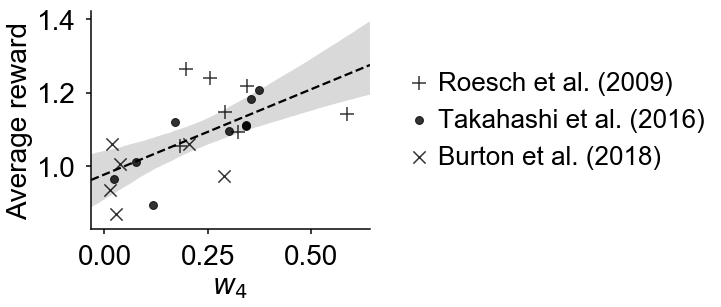

In [9]:
fig, ax = plt.subplots(figsize=(5,4))
for dataset in datasets:
    sns.regplot(x='w4', y='avgreward', data=df[df['dataset']==dataset], color='k', fit_reg=False, marker=dataset2marker[dataset], scatter_kws={'s':150*ratio_s[dataset]}, label=dataset_labels[dataset])
sns.regplot(x='w4', y='avgreward', data=df, color='k', line_kws={'linestyle':'--'}, scatter=False)

ax.set_xlabel('$w_4$')
ax.set_ylabel('Average reward')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.tick_params(axis='both', width=1.5, length=5, pad=10)
sns.despine()
ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=26, handletextpad=-0.3)

print(pearsonr(df['w4'], df['avgreward']))

### $\eta$ vs $\eta_g$ (hybrid-learning model)

#### Group-level parameters (95% HDI)

95% HDI of eta: (0.22, 0.28)
95% HDI of etag: (0.0, 0.01)


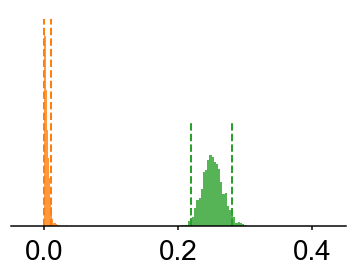

In [10]:
intervals_eta = hpd_grid(transform_eta(etas['eta_group']), alpha=0.05)[0][0]
intervals_eta4state = hpd_grid(transform_eta(etas['eta4state_group']), alpha=0.05)[0][0]
intervals_diff = hpd_grid(transform_eta(etas['eta_group'])-transform_eta(etas['eta4state_group']), alpha=0.05)[0][0]

fig, ax = plt.subplots()
sns.distplot(transform_eta(etas['eta4state_group']), kde=False, color='C1', hist_kws={'alpha':0.8}) #, label='$\eta_g$'
sns.distplot(transform_eta(etas['eta_group']), kde=False, color='C2', hist_kws={'alpha':0.8}) #, label='$\eta$'
ymin, ymax = ax.get_ylim()
ax.vlines(x=intervals_eta, ymin=ymin/2, ymax=ymax/2, color='C2', linestyle='--', linewidth=2)
ax.vlines(x=intervals_eta4state, ymin=ymin, ymax=ymax, color='C1', linestyle='--', linewidth=2)

ax.legend(frameon=False, loc='best')
# ax.set_xlabel('Learning/Generalization rate')
ax.set_yticklabels('')
ax.tick_params(axis='y', length=0)
ax.set_xlim([-0.05,0.45])
ax.tick_params(axis='x', width=1.5, pad=10)
ax.spines['bottom'].set_linewidth(1.5)
ax.xaxis.labelpad = 10
sns.despine()
ax.spines['left'].set_visible(False)

print('95% HDI of eta:', intervals_eta)
print('95% HDI of etag:', intervals_eta4state)

#### Individual animals

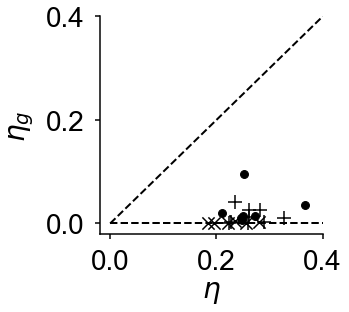

In [11]:
fig, ax = plt.subplots(figsize=(4,4))
for dataset in datasets:
    ax.scatter([np.mean(etas['eta'][:,rat-1]) for rat in dataset2rat[dataset]], [np.mean(etas['eta4state'][:,rat-1]) for rat in dataset2rat[dataset]], color='k', marker=dataset2marker[dataset], s=150*ratio_s[dataset])
ax.legend(frameon=False)
ax.set_xlabel('$\eta$')
ax.set_ylabel('$\eta_g$')
ymin, ymax = ax.get_ylim()
ax.plot([0,0.45],[0,0.45],linestyle='--', color='k', linewidth=2)
ax.plot([0,0.45],[0,0],linestyle='--', color='k', linewidth=2)
ax.set(xlim=[-0.02,0.4],ylim=[-0.02,0.4], xticks=[0,0.2,0.4])
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.yaxis.labelpad = 10
ax.tick_params(axis='both', width=1.5, length=5, pad=10)
sns.despine()

### Correlation of parameters between models

(0.9869294878571961, 0.0002551409595560176)


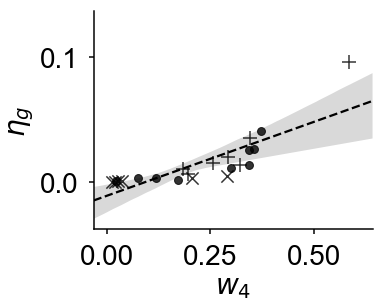

In [12]:
fig, ax = plt.subplots(figsize=(5,4))
for dataset in datasets:
    sns.regplot(x='w4', y='etag', data=df[df['dataset']==dataset], color='k', line_kws={'linestyle':'--'}, fit_reg=False, marker=dataset2marker[dataset], scatter_kws={'s':150*ratio_s[dataset]}, label=dataset_labels[dataset])
sns.regplot(x='w4', y='etag', data=df, color='k', line_kws={'linestyle':'--'}, scatter=False)
    
ax.set_xlabel('$w_4$')
ax.set_ylabel('$\eta_g$')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.tick_params(axis='both', width=1.5, length=5, pad=10)
sns.despine()

print(pearsonr(df.loc[df['dataset']==dataset, 'w4'], df.loc[df['dataset']==dataset, 'etag']))